In [1]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from tqdm import tqdm

import importlib

In [12]:
import ensembles

importlib.reload(ensembles)

<module 'ensembles' from 'C:\\bogachevv\\Python\\House_sales\\experiments\\ensembles\\__init__.py'>

In [3]:
data = pd.read_csv('kc_house_data.csv')

data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
y = data.price.to_numpy()
X = data.drop(columns=['price'])
X['date'] = pd.to_datetime(X.date.apply(lambda s: f"{s[0:4]}-{s[4:6]}-{s[6:8]}")).apply(lambda dt: dt.value)
X.drop(columns='id', inplace=True)

X.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1413158400000000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1418083200000000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,1424822400000000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,1418083200000000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1424217600000000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


_sqft\_living_ --- жилая площадь (в квадратных футах)
_sqft\_lot_ --- площадь участка (в квадратных футах)
_waterfront_ --- дом у набережной или дом у озера, реки
_sqft\_living15_ --- средняя жилая площадь у ближайших 15 домов
_sqft\_lot15_ --- средняя площадь участка и ближайших 15 домов

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"{X_train.shape=}")
print(f"{X_test.shape=}")

X_train.shape=(17290, 19)
X_test.shape=(4323, 19)


In [13]:
boosting = ensembles.GradientBoostingMSE(
    n_estimators=1_000,
    feature_subsample_size=12,
    random_state=42,
    max_depth=7,
    learning_rate=0.05
)

boosting = Pipeline([
    ('scale', StandardScaler()),
    ('forest', boosting)
])

boosting.fit(X_train, y_train)

i=  0	np.linalg.norm(S)=81180183.715359225869
i=  1	np.linalg.norm(S)=77371823.153245389462
i=  2	np.linalg.norm(S)=73763263.771889269352
i=  3	np.linalg.norm(S)=70328242.732109054923
i=  4	np.linalg.norm(S)=67057556.316904388368
i=  5	np.linalg.norm(S)=63963772.721109867096
i=  6	np.linalg.norm(S)=61020803.466053776443
i=  7	np.linalg.norm(S)=58243699.598232612014
i=  8	np.linalg.norm(S)=55593997.810448154807
i=  9	np.linalg.norm(S)=53093029.944404222071
i= 10	np.linalg.norm(S)=50712724.534064345062
i= 11	np.linalg.norm(S)=48464567.222485899925
i= 12	np.linalg.norm(S)=46323448.508948192000
i= 13	np.linalg.norm(S)=44306803.708253234625
i= 14	np.linalg.norm(S)=42385495.948313251138
i= 15	np.linalg.norm(S)=40574330.350003145635
i= 16	np.linalg.norm(S)=38855435.126153498888
i= 17	np.linalg.norm(S)=37233412.420752838254
i= 18	np.linalg.norm(S)=35691069.747159495950
i= 19	np.linalg.norm(S)=34229221.020649358630
i= 20	np.linalg.norm(S)=32847725.578525058925
i= 21	np.linalg.norm(S)=31538868.4

Pipeline(steps=[('scale', StandardScaler()),
                ('forest',
                 <ensembles.GradientBoostingMSE object at 0x000001A3E44A3580>)])

In [14]:
y_pred = boosting.predict(X_test)
print(f"MSE: {mean_squared_error(y_true=y_test, y_pred=y_pred) / np.mean(y_train):.0f}")
print(f"r^2: {r2_score(y_true=y_test, y_pred=y_pred):.4f}")

MSE: 35060
r^2: 0.8753


MSE: 55923
r^2: 0.8011

100%|██████████| 999/999 [06:04<00:00,  2.74it/s]


Text(0.5, 1.0, 'R^2 score')

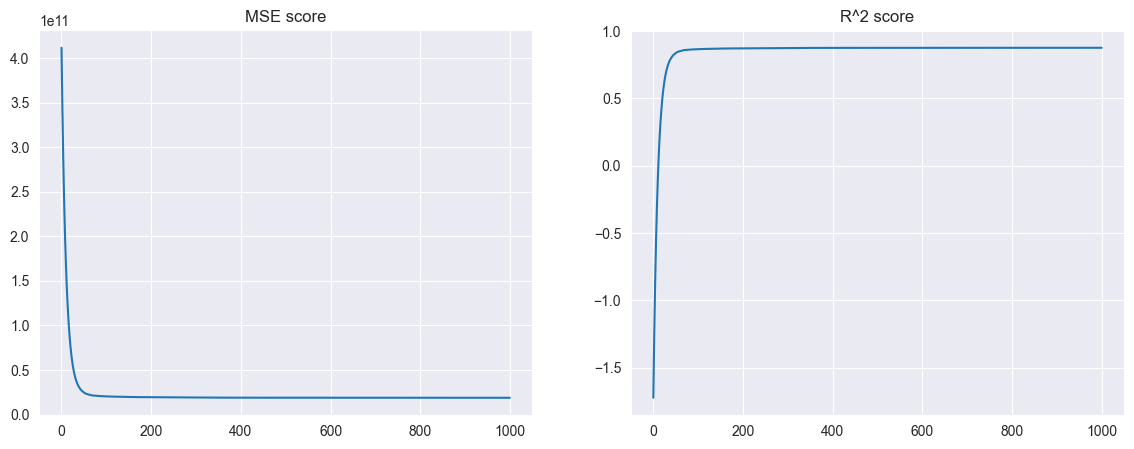

In [15]:
_, ax = plt.subplots(ncols=2, figsize=(14, 5))

estimators_cnt = np.arange(1_000 - 1) + 1
mse_score_ls = np.zeros_like(estimators_cnt, dtype=np.float64)
r2_score_ls = np.zeros_like(estimators_cnt, dtype=np.float64)

for i in tqdm(estimators_cnt):
    y_pred = boosting.predict(X_test, **{'estimators_c': i})
    mse_score_ls[i-1] = mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2_score_ls[i-1] = r2_score(y_true=y_test, y_pred=y_pred)
    
ax[0].plot(estimators_cnt, mse_score_ls)
ax[0].set_title("MSE score")

ax[1].plot(estimators_cnt, r2_score_ls)
ax[1].set_title("R^2 score")

In [16]:
feat_cnt = np.arange(X_train.shape[1] - 1) + 1
mse_score_ls = np.zeros_like(feat_cnt, dtype=np.float64)
r2_score_ls = np.zeros_like(feat_cnt, dtype=np.float64)

for i in tqdm(feat_cnt):
    mse_score_raw = []
    r2_score_raw = []
    
    for seed in [42, 11, 5647, 456, 9195, 2023]:
        boosting = ensembles.GradientBoostingMSE(
            n_estimators=500,
            feature_subsample_size=i,
            random_state=42,
            max_depth=None,
            learning_rate=0.05
        )
        
        boosting = Pipeline([
            ('scale', StandardScaler()),
            ('forest', boosting)
        ])
        
        boosting.fit(X_train, y_train)
        mse_score_raw.append(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_score_raw.append(r2_score(y_true=y_test, y_pred=y_pred))
    
    y_pred = boosting.predict(X_test)
    mse_score_ls[i-1] = np.mean(mse_score_raw)
    r2_score_ls[i-1] = np.mean(r2_score_raw)

  0%|          | 0/18 [00:00<?, ?it/s]

i=  0	np.linalg.norm(S)=80940272.604389324784
i=  1	np.linalg.norm(S)=76893259.088606104255
i=  2	np.linalg.norm(S)=73048596.254634991288
i=  3	np.linalg.norm(S)=69396167.500509917736
i=  4	np.linalg.norm(S)=65926359.181409835815
i=  5	np.linalg.norm(S)=62630041.230728156865
i=  6	np.linalg.norm(S)=59498539.169191747904
i=  7	np.linalg.norm(S)=56523612.258050307631
i=  8	np.linalg.norm(S)=53697431.745429053903
i=  9	np.linalg.norm(S)=51012560.622829660773
i= 10	np.linalg.norm(S)=48461932.601064212620
i= 11	np.linalg.norm(S)=46038835.973751693964
i= 12	np.linalg.norm(S)=43736906.550227649510
i= 13	np.linalg.norm(S)=41550061.470063284039
i= 14	np.linalg.norm(S)=39472558.396560117602
i= 15	np.linalg.norm(S)=37498930.521669030190
i= 16	np.linalg.norm(S)=35623987.653778180480
i= 17	np.linalg.norm(S)=33842788.338977076113
i= 18	np.linalg.norm(S)=32150648.933990251273
i= 19	np.linalg.norm(S)=30543131.356980178505
i= 20	np.linalg.norm(S)=29015974.852610006928
i= 21	np.linalg.norm(S)=27565176.1

  0%|          | 0/18 [00:54<?, ?it/s]

KeyboardInterrupt



In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(14, 5))

ax[0].plot(feat_cnt, mse_score_ls)
ax[0].set_title('MSE score')

ax[1].plot(feat_cnt, r2_score_ls)
ax[1].set_title('R2 score')

In [ ]:
1